In [23]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from xml.etree import ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [24]:
ls

 Volume in drive E is New Volume
 Volume Serial Number is 4839-0B3E

 Directory of e:\ISB\stanford-dogs-dataset

03-06-2024  21:59    <DIR>          .
03-06-2024  21:28    <DIR>          ..
04-06-2024  10:43    <DIR>          annotations
04-06-2024  12:38            56,450 dogs_breed_classification.ipynb
03-06-2024  22:16    <DIR>          images
               1 File(s)         56,450 bytes
               4 Dir(s)  99,118,092,288 bytes free


In [25]:
import os
from xml.etree import ElementTree as ET

def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    return xmin, ymin, xmax, ymax
pwd = r'e:\ISB\stanford-dogs-dataset' 
annotation_path = os.path.join(pwd, 'annotations', 'n02085620-Chihuahua', 'n02085620_10074')
xmin, ymin, xmax, ymax = parse_annotation(annotation_path)
print("Bounding Box Coordinates:", (xmin, ymin, xmax, ymax))


Bounding Box Coordinates: (25, 10, 276, 498)


In [26]:
def load_images_from_folders(*folders, target_size=(250, 250)):
    all_images = []
    all_labels = []
    for i, folder in enumerate(folders):
        labels = []
        images = []
        folder = folder.replace("\\", "/")
        image_classes = folder.split("/")[1]
        annotation_classes = folder.split("/")[1]
        ann_path = os.path.join('annotations', annotation_classes)
        for image_filename, annotation_filename in zip(os.listdir(folder), os.listdir(ann_path)):
            img_path = os.path.join('images', image_classes, image_filename)
            ann_path = os.path.join('annotations', annotation_classes, annotation_filename)
            xmin, ymin, xmax, ymax = parse_annotation(ann_path)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img[ymin:ymax, xmin:xmax]
            if img.shape[0] > 0 and img.shape[1] > 0:
                img = cv2.resize(img, target_size)
                images.append(img)
                labels.append(i)
            else:
                print("Skipping image:", img_path, "due to empty dimensions")

        all_images.extend(images)
        all_labels.extend(labels)
    return np.array(all_images), np.array(all_labels)


image_folders = [
    r"Images/n02085620-Chihuahua",
    r"Images/n02085936-Maltese_dog",
    r"Images/n02087046-toy_terrier",
    r"Images/n02088466-bloodhound",
    r"Images/n02107142-Doberman",
    r"Images/n02106662-German_shepherd",
    r"Images/n02108089-boxer",
    r"Images/n02112018-Pomeranian",
    r"Images/n02089867-Walker_hound",
    r"Images/n02096585-Boston_bull"
]

# Load images from the specified folders
images, labels = load_images_from_folders(*image_folders)

# Convert the lists to numpy arrays
import numpy as np
images = np.array(images)
labels = np.array(labels)

# Print the shape of the arrays
print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)


Shape of images array: (1770, 250, 250, 3)
Shape of labels array: (1770,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train = X_train / 255.0 
X_test = X_test / 255.0

data_augmentation = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

from tensorflow import keras

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(data_augmentation.flow(X_train, y_train, batch_size=64), epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1060 - loss: 2.4231 - val_accuracy: 0.2288 - val_loss: 2.1762
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2436 - loss: 2.1395 - val_accuracy: 0.3531 - val_loss: 1.9754
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.3409 - loss: 1.9397 - val_accuracy: 0.3701 - val_loss: 1.9269
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3616 - loss: 1.8354 - val_accuracy: 0.3870 - val_loss: 1.6927
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.3725 - loss: 1.7514 - val_accuracy: 0.3842 - val_loss: 1.7963
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4350 - loss: 1.6008 - val_accuracy: 0.3757 - val_loss: 1.6920
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4816 - loss: 1.4997 - val_accuracy: 0.4209 - val_loss: 1.6738
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5126 - loss: 1.4557 - val_accuracy: 0.4407 - val_loss:

In [30]:
model.save('dogs_breed_multiclassification_with_annotation.keras')

In [31]:
from tensorflow.keras.models import load_model
model = load_model('dogs_breed_multiclassification_with_annotation.keras')

In [32]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8065 - loss: 0.6014
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.5484 - loss: 1.5801


[1.5234344005584717, 0.5536723136901855]

In [33]:
named_labels = [
    "Chihuahua",
    "toy_terrier",
    "bloodhound",
    "Doberman",
    "German_shepherd",
    "boxer",
    "Pomeranian",
    "Walker_hound",
    "Boston_bullAfghan_hound"]
def show_prediction(index):
    predicted_index = np.argmax(model.predict(X_test[[index]]))
    true_value = 'True' if y_test[index] == predicted_index else 'False'
    plt.imshow(X_test[index])
    plt.title(f'Label: {named_labels[predicted_index]} ({true_value})')

    # 1 if y_test[index] == predicted_index else 0
    plt.axis('off')
    plt.show()  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


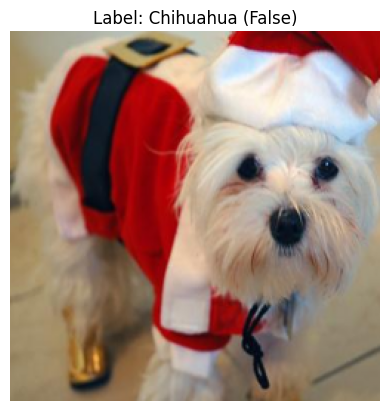

In [34]:
random = np.random.randint(340)
show_prediction(random)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


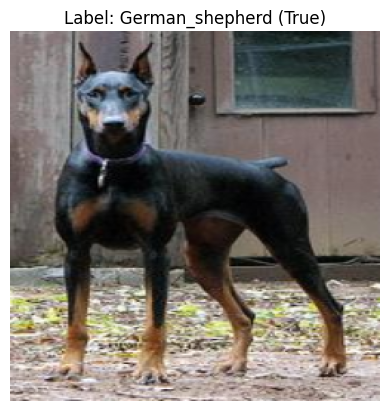

In [38]:
random = np.random.randint(340)
show_prediction(random)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


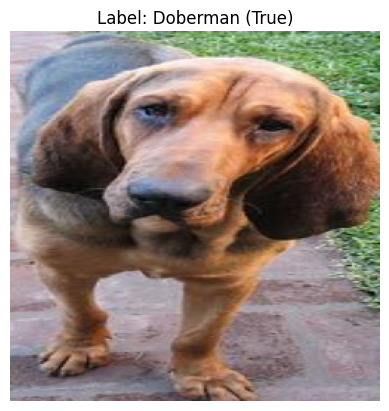

In [37]:
random = np.random.randint(340)
show_prediction(random)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


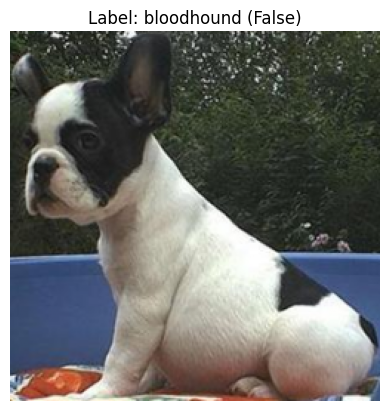

In [39]:
random = np.random.randint(340)
show_prediction(random)